In [15]:
import numpy as np
import pandas as pd
from json import dumps
from copy import deepcopy
import joblib
import shap

from sklearn.model_selection import GroupKFold, GroupShuffleSplit, KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier


In [16]:
trees = pd.read_csv('../data/raw/new_york_tree_census_2015.csv')
# print(trees.columns)

target = trees['health']
keep_rows = target.notna()

drop_cols = ['health','tree_id', 'block_id', 'created_at', 'stump_diam','status','spc_common','problems','address',\
             'zip_city','cb_num', 'borocode', 'cncldist', 'st_assem', 'st_senate', 'nta', 'boro_ct', 'state',\
             'latitude', 'longitude']

group = ['nta_name']
spatial_geo = ['x_sp','y_sp'] # encode numerical, standardize
spatial_fine = ['zipcode'] # encode categorical
spatial_coarse = ['boroname'] # encode categorical

## base ftrs, without spatial ##
numerical_ftrs = ['tree_dbh']
categorical_ftrs = ['curb_loc', 'spc_latin', 'user_type']
binary_ftrs = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', \
               'trnk_light', 'trnk_other','brch_light', 'brch_shoe', 'brch_other']
binary_cats = [['No','Yes']]*len(binary_ftrs)
ordinal_ftrs = ['steward','guards','sidewalk']
ordinal_cats = [['None','1or2','3or4','4orMore'],
                ['None','Harmful','Unsure','Helpful'],
                ['Damage','None','NoDamage']]

# check we have accounted for all columns
listed = set(drop_cols).union(group,spatial_geo,spatial_fine,spatial_coarse,\
                              numerical_ftrs,categorical_ftrs,ordinal_ftrs,binary_ftrs)
print(set(trees.columns).difference(listed) == set())

# handle ordinal ftrs to fill in na
for ftr in ordinal_ftrs:
    trees[ftr] = trees[ftr].fillna('None')

    # define feature sets
drop_cols_set = drop_cols + group # + spatial_fine + spatial_coarse
categorical_ftrs_set = categorical_ftrs + spatial_fine + spatial_coarse
numerical_ftrs_set = numerical_ftrs + spatial_geo
ordinal_ftrs_set = ordinal_ftrs + binary_ftrs
ordinal_cats_set = ordinal_cats + binary_cats

# define a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), categorical_ftrs_set),
        ('std', StandardScaler(), numerical_ftrs_set)])

True


In [17]:
RANDOM_STATE = 1
y = target[keep_rows]
le = LabelEncoder()
y = pd.DataFrame(le.fit_transform(y))
X = trees[keep_rows].drop(drop_cols_set, axis=1)
groups = trees[keep_rows][group]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

gss_eval = GroupShuffleSplit(n_splits=1, test_size=0.05, random_state=RANDOM_STATE)
sub_idx, eval_idx = next(gss_eval.split(X_train, y_train, groups_train))
X_sub, X_eval = X_train.iloc[sub_idx], X_train.iloc[eval_idx]
y_sub, y_eval = y_train.iloc[sub_idx], y_train.iloc[eval_idx]
groups_sub, groups_eval = groups_train.iloc[sub_idx], groups_train.iloc[eval_idx]

In [18]:
xg_pre = deepcopy(preprocessor)
xg_pre.fit(X)
X_sub_proc = xg_pre.transform(X_sub)
X_eval_proc = xg_pre.transform(X_eval)
X_test_proc = xg_pre.transform(X_test)
feature_names = xg_pre.get_feature_names_out()
df_test = pd.DataFrame(data=X_test_proc, columns=feature_names)

In [19]:
model = joblib.load('../models/xgb_model_72.pkl')
final_score = fbeta_score(y_test, model.predict(df_test), beta=1, average='macro')

In [20]:
baseline_preds = y_test.copy()
baseline_preds.iloc[:, 0] = 1
baseline_score = fbeta_score(y_test, baseline_preds, beta=1, average='macro')

In [21]:
print(f'model score: {final_score}')
print(f'baseline:    {baseline_score}')

model score: 0.38871698431744267
baseline:    0.2990431574273948


In [24]:
explainer = shap.TreeExplainer(model)
df_test_sample = df_test.sample(n=5_000)
shap_values = explainer.shap_values(df_test_sample, check_additivity=False)

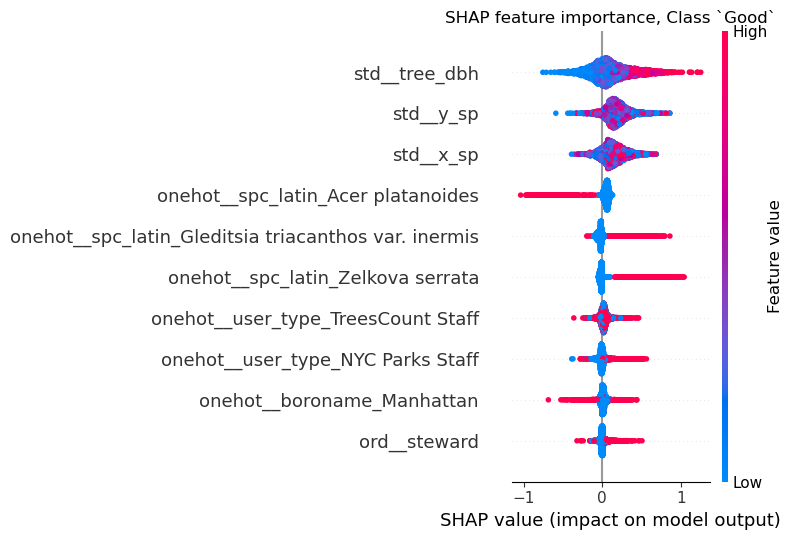

In [26]:
from matplotlib import pyplot as plt
shap.initjs()

plt.figure(figsize=(12,8))
shap.summary_plot(shap_values[:,:,1], df_test_sample, feature_names=df_test_sample.columns.tolist(), max_display=10, show=False, rng=RANDOM_STATE)
plt.title('SHAP feature importance, Class `Good`')
plt.savefig('../reports/figures/shap_Good_72.png',dpi=600,transparent=True,bbox_inches='tight')
plt.tight_layout()
plt.show()

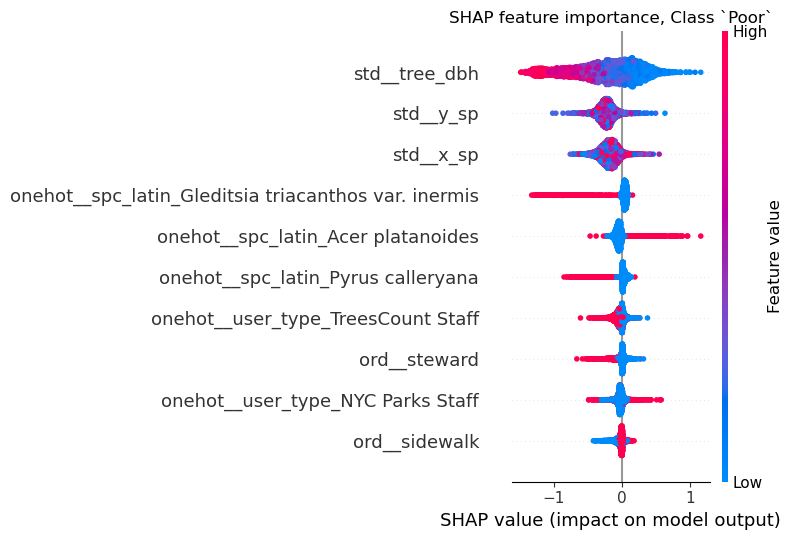

In [28]:
shap.initjs()

plt.figure(figsize=(12,8))
shap.summary_plot(shap_values[:,:,2], df_test_sample, feature_names=df_test_sample.columns.tolist(), max_display=10, show=False, rng=42)
plt.title('SHAP feature importance, Class `Poor`')
plt.tight_layout()
plt.savefig('../reports/figures/shap_Poor_72.png',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

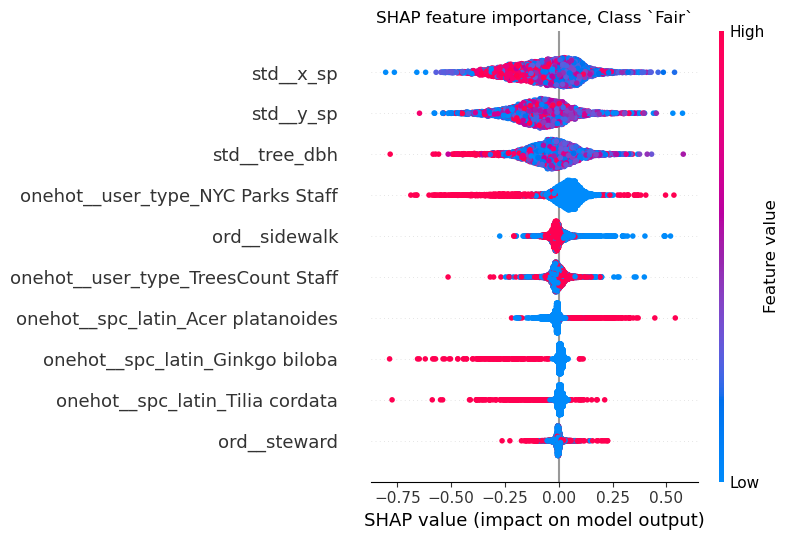

In [29]:
shap.initjs()

plt.figure(figsize=(12,8))
shap.summary_plot(shap_values[:,:,0], df_test_sample, feature_names=df_test_sample.columns.tolist(), max_display=10, show=False, rng=42)
plt.title('SHAP feature importance, Class `Fair`')
plt.tight_layout()
plt.savefig('../reports/figures/shap_Fair_72.png',dpi=600,transparent=True,bbox_inches='tight')
plt.show()